# Implementation of gradient descent and BCGD algorithms to approach a semi-supervised classification problem

Authors: Laia Porcar, Stefanija Galevska, Philippe Robert, Luis M. López

Objectives:
* Use semisupervised classification on a generated dataset and a publicly available one.
* Compare the performance of gradient desdent and some block coordinate gradient descent approaches.

# Imports and function definitions

In [1]:
import random
import numpy as np
from numpy.random import randn
from pandas import DataFrame
from matplotlib import pyplot as plt
import pandas as pd
from time import process_time

In [2]:
def plotting(points, labels, non_labeled_points = {}, nl = False):

  """Plots the given points and their labels. Also plots not labeled points 
    together with a fraction of labeled points (when nl = True and a dict of 
    non_labeled_points is provided)

    :points: points to be plotted
    :labels: labels of points to be plotted
    :non_labeled_points: dict of not labeled points to be plotted. 
    :nl: Boolean to decide if we are plotting not labeled points (True) or not 
    (False)
  """ 

  if nl == True:
    fig, ax = plt.subplots()
    plt.scatter(non_labeled_points[:,0], non_labeled_points[:,1], color='black', 
                marker = ".", alpha = 0.2)
  else: fig, ax = plt.subplots()

  df = DataFrame(dict(x=points[:,0], y=points[:,1], label=labels))
  colors = {-1:'red', 1:'blue'}
  grouped = df.groupby('label')
  for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
  plt.show()


def similarity(x_1, x_2):
    
  """Computes the similarity between two given points. The similarity is defined
    as the inverse of the euclidean distance.

    :x_1: point 1, with two coordinates
    :x_2: point 2, with two coordinates
    :return: similarity
  """ 
  distance = np.sqrt((x_1[0]-x_2[0])**2 + (x_1[1]-x_2[1])**2)
  return 1/distance

def calculate_weights(dict_points):
    
  """Calculates all weights between pairs of points and stores them in a 
  dictionary where the key is a tupple of points and the value their weight.

    :dict_points: dictionary of points
    :return: dictionary of all weights
  """ 

  dict_weights = {}
  for point1 in dict_points.keys():
    for point2 in dict_points.keys():
      if point1 != point2:
        dict_weights[(point1,point2)] = similarity(point1, point2)

  return dict_weights


def accuracy_calculator(original_nonlabeled, nonlabeled):
    
  """Computes the accuracy of the classification of unlabeled points.

    :original_non_labeled: dict of not labeled points as key, and their original
     labels as value.
    :non_labeled: dict of not labeled points as key, and their calculated
     labels as value.
    :return: accuracy
  """ 
  total = len(original_nonlabeled)
  correct = 0

  for key in original_nonlabeled.keys():
    if nonlabeled[key] == original_nonlabeled[key]:
      correct += 1
  accuracy = correct/total
  return accuracy

def gradient_yj(x_j, y_j, dict_nonlabeled, dict_labeled, dict_weights):

  """Computes the gradient of the function for a specific point passed as argument.

    :x_j: point for which the gradient will be computed.
    :y_j: label of the point for which the gradient will be computed.
    :dict_nonlabeled: dict of not labeled points as keys and their initialized 
    labels as value.
    :dict_labeled: dict of labeled points as keys and their labels as value.
    :return: gradient
  """ 
  # List comprehensions because append method is costly
  first_term_gradient = [(dict_weights[x_j, x_i] * (y_j - y_i)) for x_i, y_i in dict_labeled.items()]
  second_term_gradient = [(dict_weights[x_j, x_i] * (y_j - y_i)) for x_i, y_i in dict_nonlabeled.items() if x_i != x_j]

  gradient = 2*sum(first_term_gradient) + 2*sum(second_term_gradient)
  return gradient

def func(dict_nonlabeled, dict_labeled, dict_weights):

  """Computes the value of the function.

    :x_j: point for which the gradient will be computed.
    :y_j: label of the point for which the gradient will be computed.
    :dict_nonlabeled: dict of not labeled points as keys and their initialized 
    labels as value.
    :dict_labeled: dict of labeled points as keys and their labels as value.
    :return: gradient
  """ 
  
  first_term_gradient = []
  second_term_gradient = []
  # List comprehensions because append method is costly
  first_term_gradient = [(dict_weights[x_j, x_i] * (y_j - y_i)*(y_j - y_i)) for x_j, y_j in dict_nonlabeled.items() for x_i, y_i in dict_labeled.items()]
  second_term_gradient = [(dict_weights[x_j, x_i] * (y_j - y_i)*(y_j - y_i)) for x_j, y_j in dict_nonlabeled.items() for x_i, y_i in dict_nonlabeled.items() if x_i != x_j]

  values_func = sum(first_term_gradient) + 0.5*sum(second_term_gradient)

  return values_func




## Generating Data and setup

In [3]:
def data_generation(n_points = 1000, subset_size = 0.02):
    
  """Generates the data: two clusters of points with labels 1 and -1. Same 
    number of points in each cluster. Normal distribution of the points in the 
    clusters. Remove the labels of a fraction of points.

    :n_points: number of points to be generated.
    :subset_size: fraction of points to be left with their original labels.
    :return: list of labeled points (labeled_points), list of not labeled points
    (non_labeled_points), labels of the labeled points (labels) and list of 
    labels that have been removed from the not labeled points (labels_check).
  """ 
  points_dict = {}
  points_list, labels_list = [], []

  # Generate two sets of points, each set belonging to a certain label

  for i in range(int(n_points/2)):
    points_dict[(3 + randn(), randn())] = 1
    points_dict[(1.5*randn(), 4 + randn())] = -1


  # for key, value in points_dict.items():
  #   points_list.append(key)
  #   labels_list.append(value)

  points_list = [key for key in points_dict.keys()]
  labels_list = [value for value in points_dict.values()]


  # Only keep a percentage of the labels 
  number_points_subset = int(subset_size * len(points_list))
  labeled_points = points_list[:number_points_subset]
  labels = labels_list[:number_points_subset]
  non_labeled_points = points_list[number_points_subset:]
  labels_check = labels_list[number_points_subset:]

  print(f"Generated data with {n_points} points and {100* subset_size}% of label points")

  # Plot the two initially generated clusters:
  plotting(np.array(points_list), np.array(labels_list))

  # Plot non labeled points and labeled_points
  plotting(np.array(labeled_points), np.array(labels), np.array(non_labeled_points), nl = True)

  return labeled_points, non_labeled_points, labels, labels_check

In [5]:
def setup_points(n_points = 1000, subset_size = 0.02):

  """Calls the data generation function and set ups the data into dictionaries, 
    including the generation of initialized labels for the not labeled points 
    and the computation of the gradients for all points.

    :n_points: number of points to be generated.
    :subset_size: fraction of points to be left with their original labels.
    :return: dict of labeled points as key and their labels as value
    (dict_labeled), dict of not labeled points as key and the initialized 
    labels as value (dict_nonlabeled), dict of not labeled points as key 
    and their original labels as value (labels_check) and dict of precomputed 
    weights of all points (dict_weights).
  """ 

  # Generate the data
  labeled_points, non_labeled_points, labels, labels_check = data_generation(n_points, subset_size)

  non_labeled_points = [tuple(x) for x in non_labeled_points]
  labeled_points = [tuple(x) for x in labeled_points]

  init_labels = [0] * len(non_labeled_points) # initialize labels for nonlabeled points

  dict_nonlabeled = dict(zip(non_labeled_points, init_labels)) # dict with nonlabeled points and their initialized labels
  dict_labeled = dict(zip(labeled_points, labels)) # dict with labeled points and their labels
  dict_check = dict(zip(non_labeled_points, labels_check)) # dict with non labeled points and their original labels. useful to calculate accuracy later

  dict_weights =  calculate_weights({**dict_labeled, **dict_nonlabeled})

  return dict_nonlabeled, dict_labeled, dict_check, dict_weights

## Gradient Descent 

In [4]:
def gradient_descent(dict_nonlabeled, dict_labeled, dict_check, dict_weights, alpha, grad_thres, to_plot):
   
  """Makes a classification of the not labeled points using gradient descent 
    and plots the result. Prints achived accuracy. Blocks of size 1.

    :alpha: fixed step size
    :grad_thres: the minimum size of the gradient, used as stopping condition.
    :to_plot: Boolean. Wether we want to plot the original and resulting 
    classification (True) or not (False).
    :dict_non_labeled: dict of not labeled points as key and their initialized 
    labels as value.
    :dict_labeled: dict of labeled points as key and their labels as value.
    :dict_check: dict of not labeled points as key and their original labels 
    as value.
    :dict_weights: dict of precomputed weights of all points.
    :return: vector of computed values of the loss function (func_values) and 
    vector of times after each iteration (CPU time).
  """ 
  stop_cond = False
  time_total = 0
  func_values, cpu_time =  [], []

  while stop_cond == False:
    # iterations += 1
    # if iterations%3 == 0:
    func_values.append(func(dict_nonlabeled, dict_labeled, dict_weights))
    t_before = process_time()
    for x_j, y_j in dict_nonlabeled.items():
      grad = gradient_yj(x_j, y_j, dict_nonlabeled, dict_labeled, dict_weights)
      dict_nonlabeled[x_j] = y_j - alpha * grad
      if abs(grad) < grad_thres:
        stop_cond = True
    t_after = process_time()
    time_total += (t_after - t_before) 
    cpu_time.append(time_total)

  func_values.append(func(dict_nonlabeled, dict_labeled, dict_weights))
  for x_j, y_j in dict_nonlabeled.items():
    if y_j >= 0:
      dict_nonlabeled[x_j] = 1
    else:
      dict_nonlabeled[x_j] = -1 

  all_points = {**dict_labeled, **dict_nonlabeled}
  accuracy = accuracy_calculator(dict_check, dict_nonlabeled)
  print(f"Nonlabeled points have been classified with an accuracy of {accuracy} and alpha {alpha}.")

  #### Plotting part ##############

  if to_plot == True:
    # Let's see the new classification
    all_points_list = [[key[0], key[1]] for key in all_points.keys()]
    all_points_list = np.array(all_points_list)
    plotting(all_points_list, all_points.values())

  return func_values, cpu_time

## Cyclic rule

In [6]:
def cyclic_rule(dict_nonlabeled, dict_labeled, dict_check, dict_weights, alpha, grad_thres, to_plot):
    
  """Makes a classification of the not labeled points using block gradient descent with the cyclic rule
    and plots the result. Prints achived accuracy. Blocks of size 1.

    :alpha: fixed step size
    :grad_thres: the minimum size of the gradient, used as stopping condition.
    :to_plot: Boolean. Wether we want to plot the original and resulting 
    classification (True) or not (False).
    :dict_non_labeled: dict of not labeled points as key and their initialized 
    labels as value.
    :dict_labeled: dict of labeled points as key and their labels as value.
    :dict_check: dict of not labeled points as key and their original labels 
    as value.
    :dict_weights: dict of precomputed weights of all points.
    :return: vector of computed values of the loss function (func_values) and 
    vector of times after each iteration (CPU time).
  """ 
  stop_cond = False
  time_total = 0
  func_values,cpu_time =  [], []

  #gradient = {}

  while stop_cond == False:
    func_values.append(func(dict_nonlabeled, dict_labeled, dict_weights))
    t_before = process_time()
    gradient = {}
    for x_j, y_j in dict_nonlabeled.items():
      gradient[x_j] = gradient_yj(x_j, y_j, dict_nonlabeled, dict_labeled, dict_weights)
      if abs(gradient[x_j]) < grad_thres:
        stop_cond = True

    for x_j, y_j in dict_nonlabeled.items(): 
      dict_nonlabeled[x_j] = y_j - alpha * gradient[x_j]

    t_after = process_time()
    time_total += (t_after - t_before)
    cpu_time.append(time_total)

  func_values.append(func(dict_nonlabeled, dict_labeled, dict_weights))
  for x_j, y_j in dict_nonlabeled.items():
    if y_j >= 0:
      dict_nonlabeled[x_j] = 1
    else:
      dict_nonlabeled[x_j] = -1 

  all_points = {**dict_labeled, **dict_nonlabeled}
  accuracy = accuracy_calculator(dict_check, dict_nonlabeled)
  print(f"Nonlabeled points have been classified with an accuracy of {accuracy} and alpha {alpha}.")

  #### Plotting part ##############

  if to_plot == True:
    # Let's see the new classification
    all_points_list = [[key[0], key[1]] for key in all_points.keys()]
    all_points_list = np.array(all_points_list)
    plotting(all_points_list, all_points.values())

  return func_values, cpu_time

## BCGD with randomized rule

 replace = False --> random permutation
 replace = True --> random sampling

In [7]:
def randomized_rule(dict_nonlabeled, dict_labeled, dict_check, dict_weights, alpha, grad_thres, to_plot, replace = False):
    
  """Makes a classification of the not labeled points using block gradient descent with the randomized rule
    and plots the result. Prints achived accuracy. Blocks of size 1.

    :alpha: fixed step size
    :grad_thres: the minimum size of the gradient, used as stopping condition.
    :to_plot: Boolean. Wether we want to plot the original and resulting 
    classification (True) or not (False).
    :replace: Boolean. Wether the randomly picked points are picked with 
    replacement (True, random sampling) or not (False, random permutations).
    :dict_non_labeled: dict of not labeled points as key and their initialized 
    labels as value.
    :dict_labeled: dict of labeled points as key and their labels as value.
    :dict_check: dict of not labeled points as key and their original labels 
    as value.
    :dict_weights: dict of precomputed weights of all points.
    :return: vector of computed values of the loss function (func_values) and 
    vector of times after each iteration (CPU time).
  """ 
  stop_cond = False
  time_total = 0
  func_values, cpu_time =  [], []


  while stop_cond == False:
    func_values.append(func(dict_nonlabeled, dict_labeled, dict_weights))
    list_keys = [x for x in dict_nonlabeled.keys()]
    index_list = np.random.choice(range(len(list_keys)), len(list_keys), replace = replace)

    t_before = process_time()
    for i in index_list:
      x_j = list_keys[i]
      y_j = dict_nonlabeled[x_j]
      grad = gradient_yj(x_j, y_j, dict_nonlabeled, dict_labeled, dict_weights)
      dict_nonlabeled[x_j] = y_j - alpha * grad
      
      if abs(grad) < grad_thres and replace == True:
        stop_cond = True
      if abs(grad) < grad_thres and replace == False:
        stop_cond = True
        break

    t_after = process_time()
    time_total += (t_after - t_before)
    cpu_time.append(time_total)

  func_values.append(func(dict_nonlabeled, dict_labeled, dict_weights))
  for x_j, y_j in dict_nonlabeled.items():
    if y_j > 0:
      dict_nonlabeled[x_j] = 1
    elif y_j == 0:
      dict_nonlabeled[x_j] = int(np.random.choice([-1,1], 1))
    elif y_j < 0:
      dict_nonlabeled[x_j] = -1 

  all_points = {**dict_labeled, **dict_nonlabeled}
  accuracy = accuracy_calculator(dict_check, dict_nonlabeled)
  print(f"Nonlabeled points have been classified with an accuracy of {accuracy} and alpha {alpha}.")

  #### Plotting part ##############

  if to_plot == True:
    # Let's see the new classification
    all_points_list = [[key[0], key[1]] for key in all_points.keys()]
    all_points_list = np.array(all_points_list)
    plotting(all_points_list, all_points.values())

  return func_values, cpu_time

In [8]:
def randomized_rule2(dict_nonlabeled, dict_labeled, dict_check, dict_weights, alpha, grad_thres, to_plot, replace = False):
    
  """Makes a classification of the not labeled points using block gradient descent with the randomized rule
    and plots the result. Prints achived accuracy. Blocks of size 1.

    :alpha: fixed step size
    :grad_thres: the minimum size of the gradient, used as stopping condition.
    :to_plot: Boolean. Wether we want to plot the original and resulting 
    classification (True) or not (False).
    :replace: Boolean. Wether the randomly picked points are picked with 
    replacement (True, random sampling) or not (False, random permutations).
    :dict_non_labeled: dict of not labeled points as key and their initialized 
    labels as value.
    :dict_labeled: dict of labeled points as key and their labels as value.
    :dict_check: dict of not labeled points as key and their original labels 
    as value.
    :dict_weights: dict of precomputed weights of all points.
    :return: vector of computed values of the loss function (func_values) and 
    vector of times after each iteration (CPU time).
  """ 
  stop_cond = False
  time_total = 0
  func_values, cpu_time =  [], []
  # gradient = {}

  while stop_cond == False:
    func_values.append(func(dict_nonlabeled, dict_labeled, dict_weights))
    list_keys = [x for x in dict_nonlabeled.keys()]
    index_list = np.random.choice(range(len(list_keys)), len(list_keys), replace = replace)

    gradient = {}
    t_before = process_time()

    for i in index_list:
      x_j = list_keys[i]
      y_j = dict_nonlabeled[x_j]
      gradient[x_j] = gradient_yj(x_j, y_j, dict_nonlabeled, dict_labeled, dict_weights)

      if abs(gradient[x_j]) < grad_thres and replace == False:
        stop_cond = True
      if abs(gradient[x_j]) < grad_thres and replace == True:
        stop_cond = True
        break

    # if replace == True:
    #   for x_j, y_j in dict_nonlabeled.items(): 
    #     if x_j in gradient.keys():
    #       dict_nonlabeled[x_j] = y_j - alpha * gradient[x_j]

    # if replace == False:    
    #   for x_j, y_j in dict_nonlabeled.items(): 
    #     dict_nonlabeled[x_j] = y_j - alpha * gradient[x_j]

    for x_j, y_j in dict_nonlabeled.items(): 
      if x_j in gradient.keys():
        dict_nonlabeled[x_j] = y_j - alpha * gradient[x_j]


    t_after = process_time()
    time_total += (t_after - t_before)
    cpu_time.append(time_total)

  func_values.append(func(dict_nonlabeled, dict_labeled, dict_weights))

  for x_j, y_j in dict_nonlabeled.items():
    if y_j > 0:
      dict_nonlabeled[x_j] = 1
    elif y_j == 0:
      dict_nonlabeled[x_j] = int(np.random.choice([-1,1], 1))
    elif y_j < 0:
      dict_nonlabeled[x_j] = -1 

  all_points = {**dict_labeled, **dict_nonlabeled}
  accuracy = accuracy_calculator(dict_check, dict_nonlabeled)
  print(f"Nonlabeled points have been classified with an accuracy of {accuracy} and alpha {alpha}.")

  #### Plotting part ##############

  if to_plot == True:
    # Let's see the new classification
    all_points_list = [[key[0], key[1]] for key in all_points.keys()]
    all_points_list = np.array(all_points_list)
    plotting(all_points_list, all_points.values())

  return func_values, cpu_time

# Running the algorithms

Generated data with 6000 points and 1.0% of label points


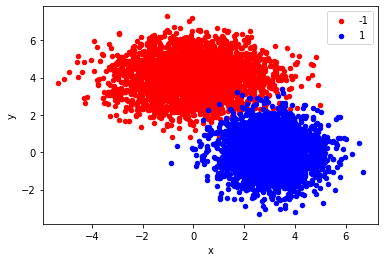

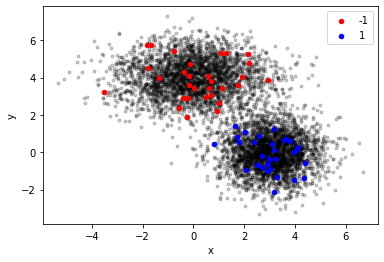

CPU times: user 1min 27s, sys: 5.47 s, total: 1min 32s
Wall time: 1min 34s


In [9]:
%%time
dict_nonlabeled, dict_labeled, dict_check, dict_weights = setup_points(n_points = 6000, subset_size = 0.01)

Nonlabeled points have been classified with an accuracy of 0.9888888888888889 and alpha 1e-05.


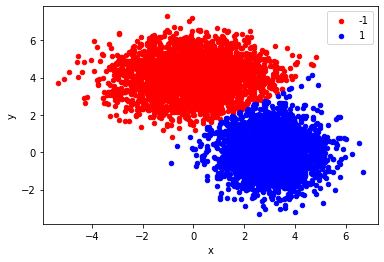

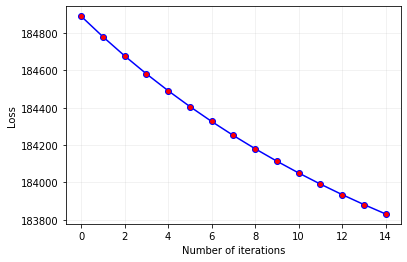

CPU times: user 22min 44s, sys: 19.9 s, total: 23min 4s
Wall time: 23min 6s


In [11]:
%%time 
func_values_gdo, cpu_time_gdo = gradient_descent(dict(dict_nonlabeled), dict(dict_labeled), dict(dict_check), dict(dict_weights), alpha = 0.00001, grad_thres = 0.005, to_plot = True)

fig, ax = plt.subplots()
plt.grid(alpha = 0.2)
plt.plot(func_values_gdo, color='blue', marker = 'o', markerfacecolor = 'r')
ax.set_ylabel("Loss")
ax.set_xlabel("Number of iterations")
plt.show()

Nonlabeled points have been classified with an accuracy of 0.9887205387205387 and alpha 3e-05.


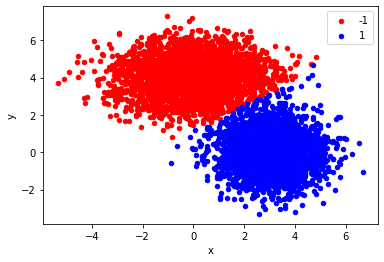

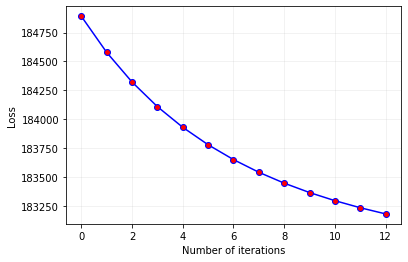

CPU times: user 18min 30s, sys: 9.76 s, total: 18min 39s
Wall time: 18min 39s


In [12]:
%%time
func_values_cro, cpu_time_cro = cyclic_rule(dict(dict_nonlabeled), dict(dict_labeled), dict(dict_check), dict(dict_weights), alpha = 0.00003, grad_thres = 0.003, to_plot = True)

fig, ax = plt.subplots()
plt.grid(alpha = 0.2)
plt.plot(func_values_cro, color='blue', marker = 'o', markerfacecolor = 'r')
ax.set_ylabel("Loss")
ax.set_xlabel("Number of iterations")
plt.show()

Nonlabeled points have been classified with an accuracy of 0.9890572390572391 and alpha 1e-05.


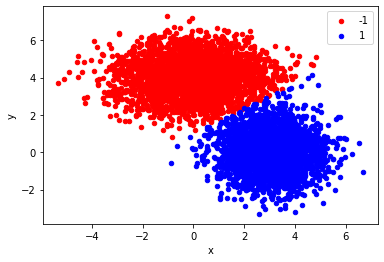

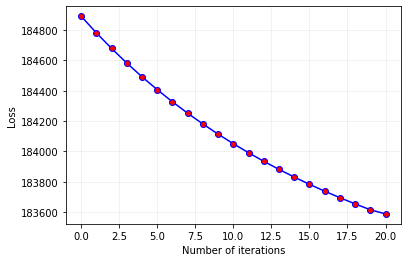

CPU times: user 31min 49s, sys: 12.8 s, total: 32min 2s
Wall time: 32min 5s


In [13]:
%%time
func_values_rro, cpu_time_rro = randomized_rule(dict(dict_nonlabeled), dict(dict_labeled), dict(dict_check), dict(dict_weights), alpha = 0.00001, grad_thres = 0.005, to_plot = True, replace = False)

fig, ax = plt.subplots()
plt.grid(alpha = 0.2)
plt.plot(func_values_rro, color='blue', marker = 'o', markerfacecolor = 'r')
ax.set_ylabel("Loss")
ax.set_xlabel("Number of iterations")
plt.show()

Nonlabeled points have been classified with an accuracy of 0.9853535353535353 and alpha 3e-05.


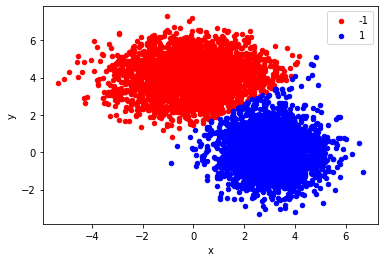

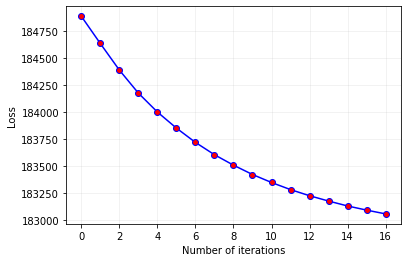

CPU times: user 27min 6s, sys: 8.95 s, total: 27min 15s
Wall time: 27min 19s


In [15]:
%%time
func_values_rrro, cpu_time_rrro = randomized_rule(dict(dict_nonlabeled), dict(dict_labeled), dict(dict_check), dict(dict_weights), alpha = 0.00003, grad_thres = 0.003, to_plot = True, replace = True)

fig, ax = plt.subplots()
plt.grid(alpha = 0.2)
plt.plot(func_values_rrro, color='blue', marker = 'o', markerfacecolor = 'r')
ax.set_ylabel("Loss")
ax.set_xlabel("Number of iterations")
plt.show()

## Analysis of loss vs CPU time and number of iterations

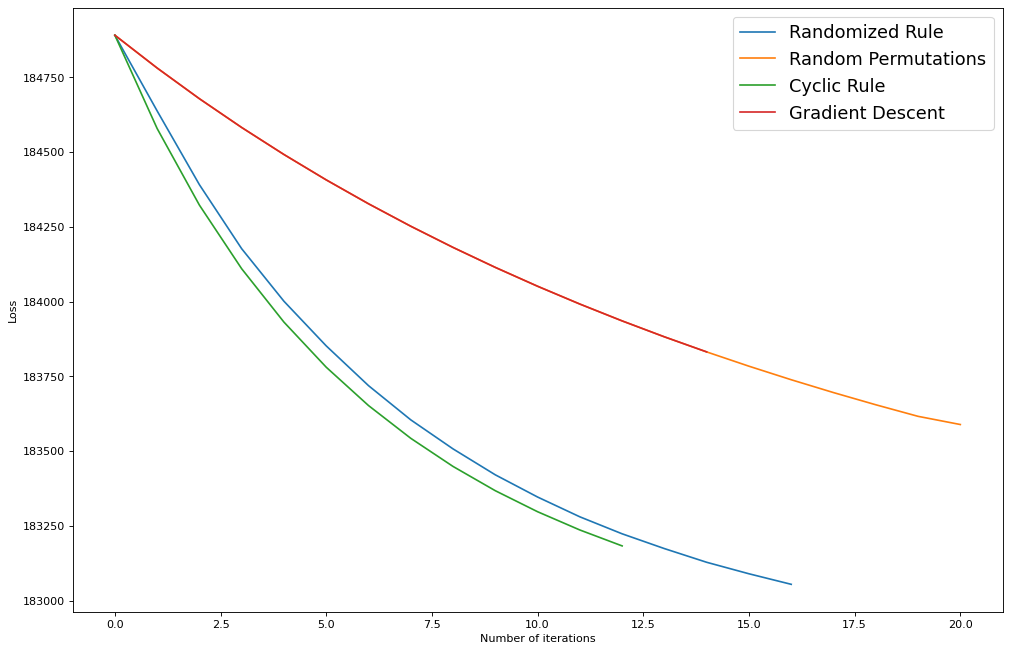

In [40]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=80)
# plt.xlim(-1, 50)
# plt.ylim(65000, 77500)
plt.plot(func_values_rrro, label = "Randomized Rule")
plt.plot(func_values_rro, label = "Random Permutations")
plt.plot(func_values_cro, label = "Cyclic Rule")
plt.plot(func_values_gdo, label = "Gradient Descent")
ax.set_ylabel("Loss")
ax.set_xlabel("Number of iterations")
plt.legend(loc=1, prop={'size': 16})
plt.show()

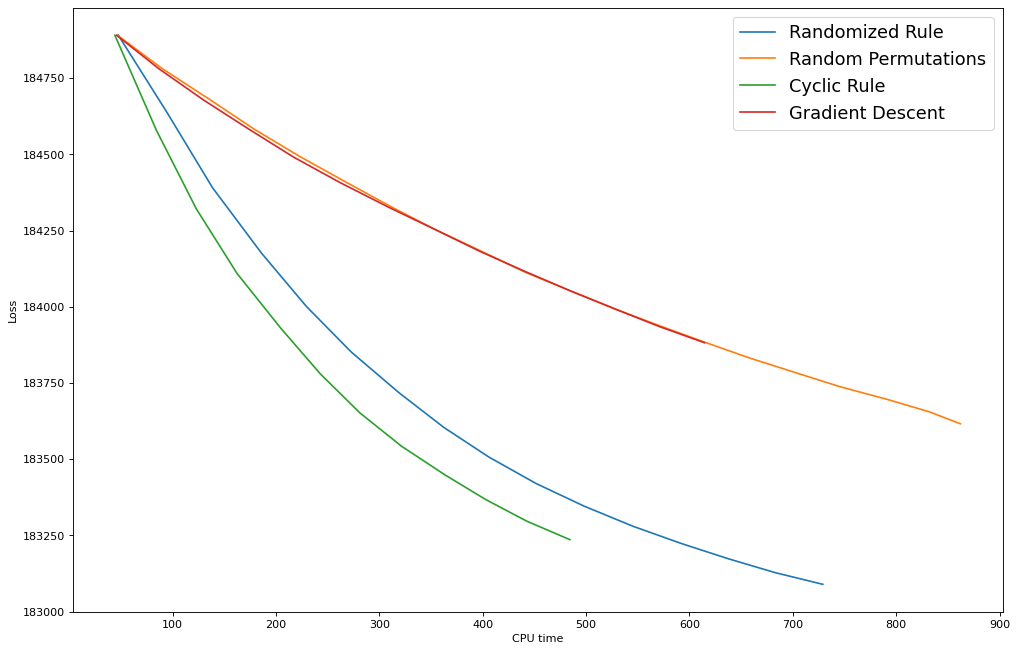

In [41]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=80)
# plt.xlim(-1, 50)
# plt.ylim(65000, 77500)
plt.plot(cpu_time_rrro,func_values_rrro[:-1], label = "Randomized Rule")
plt.plot(cpu_time_rro,func_values_rro[:-1], label = "Random Permutations")
plt.plot(cpu_time_cro,func_values_cro[:-1], label = "Cyclic Rule")
plt.plot(cpu_time_gdo,func_values_gdo[:-1], label = "Gradient Descent")
ax.set_ylabel("Loss")
ax.set_xlabel("CPU time")
plt.legend(loc=1, prop={'size': 16})
plt.show()

# Test on a dataset extracted from Kaggle

In [18]:
def setup_kd(subset_size = 0.2, to_plot = False, basic_info_df = False):
    
  """Imports and clean dataset. Chooses two features to be used as points and the
    labels. Split the points into a labeled set and an unlabeled set.

    :subset_size: fraction of points to be left with their original labels.
    :to_plot: Boolean. Wether to plot the original cluster and the 
    classification (True) or not (False).
    :basic_info_df: Boolean. Wether to print basic information of the dataset 
    (True) or not (False).
    :return: dict of labeled points as key and their labels as value
    (kd_labeled), dict of not labeled points as key and the initialized 
    labels as value (kd_nonlabeled), and dict of not labeled points as key 
    and their original labels as value (kd_check).
  """ 

  from google.colab import drive
  drive.mount('/content/drive')
  df = pd.read_csv("drive/MyDrive/Colab Notebooks/breast_cancer.csv")
  #print(df.head())

  column_1 = "radius_mean"
  column_2 = "symmetry_mean"

  # We can keep only the "radius_mean", "texture_mean" and "diagnosis" columns
  df = df[["diagnosis", column_1, column_2]]

  # Let's convert all M to -1 and B to 1
  df['diagnosis'] = df['diagnosis'].replace(['M', "B"], [-1 ,1])
  check_for_nan = df.isnull().values.any() # Check for nan values

  if basic_info_df == True:
    print("Are there nan values? ", check_for_nan)
    print(df.head())

  # Let's get rid of some labels to see if we are able to correctly predict them

  number_points_subset = int(subset_size * len(df))

  df_labeled = df.iloc[:number_points_subset, :]
  df_nonlabeled = df.iloc[number_points_subset:, :]
  df_nonlabeled = df_nonlabeled.reset_index()


  labeled_points = [(df_labeled[column_1][i], df_labeled[column_2][i]) 
                    for i in range(len(df_labeled))]
  labels = df_labeled["diagnosis"]
  non_labeled_points = [(df_nonlabeled[column_1][i],
                        df_nonlabeled[column_2][i]) 
                        for i in range(len(df_nonlabeled))]
  labels_to_check = df_nonlabeled["diagnosis"]
  labels_init = [0] * len(non_labeled_points)

  kd_labeled = dict(zip(labeled_points, labels)) # kd stands for kaggle data
  kd_nonlabeled = dict(zip(non_labeled_points, labels_init))
  kd_check = dict(zip(non_labeled_points, labels_to_check))

  dict_weights = calculate_weights({**kd_labeled, **kd_nonlabeled})

  #### Plotting part ##############

  if to_plot == True:
    # Let's visualize the original data
    plotting(np.array(df[[column_1, column_2]]),
            np.array(df["diagnosis"]))

    # Plot non labeled points and labeled_points
    plotting(np.array(labeled_points), np.array(labels),
            np.array(non_labeled_points), nl = True)
  return kd_labeled, kd_nonlabeled, kd_check, dict_weights 


# Running the algorithms on the kaggle data

Mounted at /content/drive


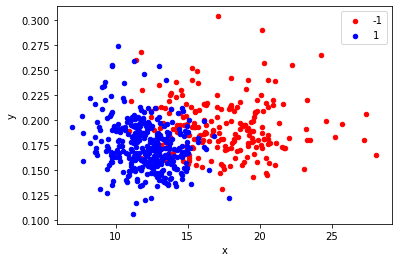

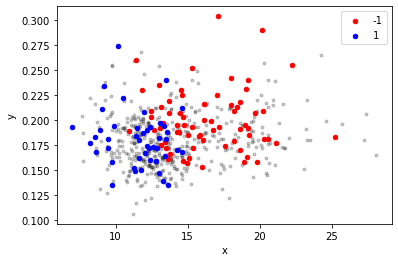

In [19]:
kd_labeled, kd_nonlabeled, kd_check, kd_weights = setup_kd(subset_size = 0.2, to_plot = True, basic_info_df = False)

Nonlabeled points have been classified with an accuracy of 0.7916666666666666 and alpha 1e-05.


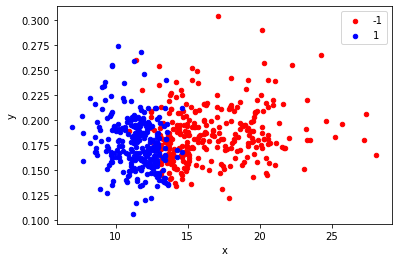

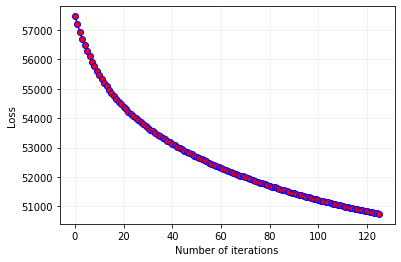

CPU times: user 1min 5s, sys: 291 ms, total: 1min 5s
Wall time: 1min 9s


In [20]:
%%time
func_values_gd, cpu_time_gd = gradient_descent(dict(kd_nonlabeled), dict(kd_labeled), dict(kd_check), dict(kd_weights), alpha = 0.00001, grad_thres = 0.001, to_plot = True)

fig, ax = plt.subplots()
plt.grid(alpha = 0.2)
plt.plot(func_values_gd, color='blue', marker = 'o', markerfacecolor = 'r')
ax.set_ylabel("Loss")
ax.set_xlabel("Number of iterations")
plt.show()

Nonlabeled points have been classified with an accuracy of 0.7916666666666666 and alpha 1e-05.


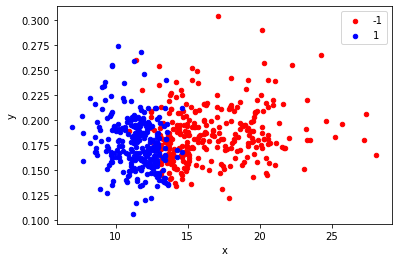

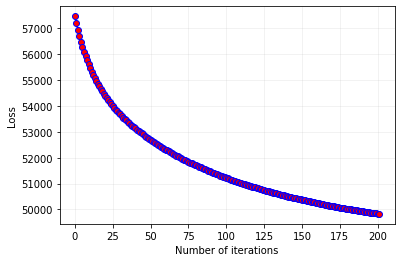

CPU times: user 1min 51s, sys: 440 ms, total: 1min 52s
Wall time: 2min 1s


In [21]:
%%time
func_values_cr, cpu_time_cr = cyclic_rule(dict(kd_nonlabeled), dict(kd_labeled), dict(kd_check), dict(kd_weights),  alpha = 0.00001, grad_thres = 0.001, to_plot = True)

fig, ax = plt.subplots()
plt.grid(alpha = 0.2)
plt.plot(func_values_cr, color='blue', marker = 'o', markerfacecolor = 'r')
ax.set_ylabel("Loss")
ax.set_xlabel("Number of iterations")
plt.show()

Nonlabeled points have been classified with an accuracy of 0.7916666666666666 and alpha 1e-05.


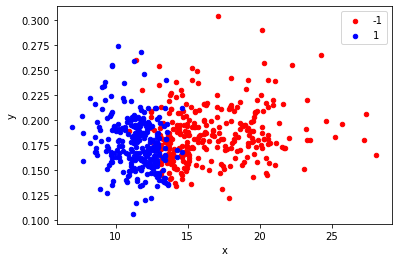

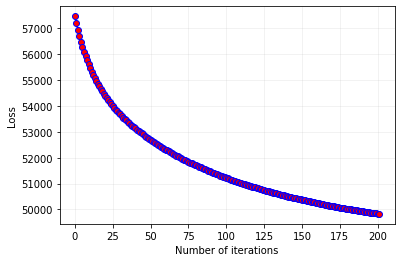

CPU times: user 1min 44s, sys: 436 ms, total: 1min 44s
Wall time: 1min 45s


In [22]:
%%time
func_values_rr, cpu_time_rr = randomized_rule2(dict(kd_nonlabeled), dict(kd_labeled), dict(kd_check), dict(kd_weights),  alpha = 0.00001, grad_thres = 0.001, to_plot = True, replace = False)

fig, ax = plt.subplots()
plt.grid(alpha = 0.2)
plt.plot(func_values_rr, color='blue', marker = 'o', markerfacecolor = 'r')
ax.set_ylabel("Loss")
ax.set_xlabel("Number of iterations")
plt.show()

Nonlabeled points have been classified with an accuracy of 0.7916666666666666 and alpha 1e-05.


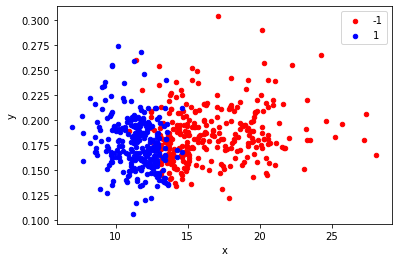

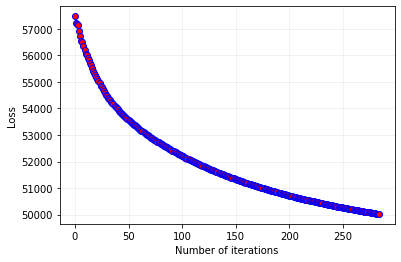

CPU times: user 2min 21s, sys: 580 ms, total: 2min 21s
Wall time: 2min 23s


In [23]:
%%time
# With replacement
func_values_rrr, cpu_time_rrr = randomized_rule2(dict(kd_nonlabeled), dict(kd_labeled), dict(kd_check), dict(kd_weights),  alpha = 0.00001, grad_thres = 0.001, to_plot = True, replace = True)

fig, ax = plt.subplots()
plt.grid(alpha = 0.2)
plt.plot(func_values_rrr, color='blue', marker = 'o', markerfacecolor = 'r')
ax.set_ylabel("Loss")
ax.set_xlabel("Number of iterations")
plt.show()

## Analysis of loss vs CPU time and number of iterations

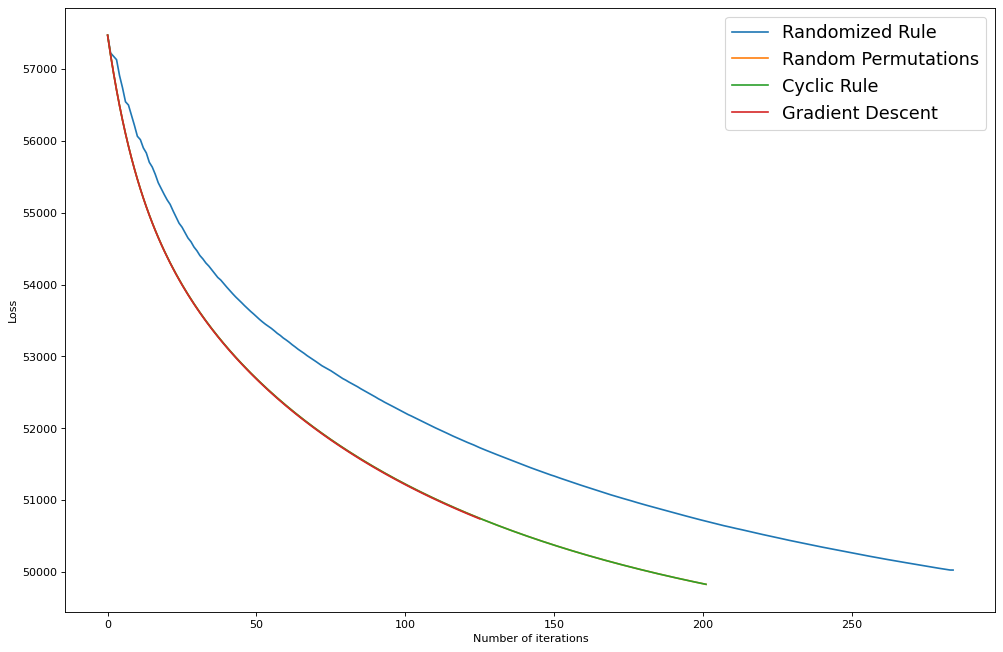

In [36]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=80)
# plt.xlim(-1, 100)
# plt.ylim(65000, 77500)

plt.plot(func_values_rrr, label = "Randomized Rule")
plt.plot(func_values_rr, label = "Random Permutations")
plt.plot(func_values_cr, label = "Cyclic Rule")
plt.plot(func_values_gd, label = "Gradient Descent")


ax.set_ylabel("Loss")
ax.set_xlabel("Number of iterations")
plt.legend(loc=1, prop={'size': 16})
# plt.savefig(fname = "Loss_vs_iterations")
plt.show()

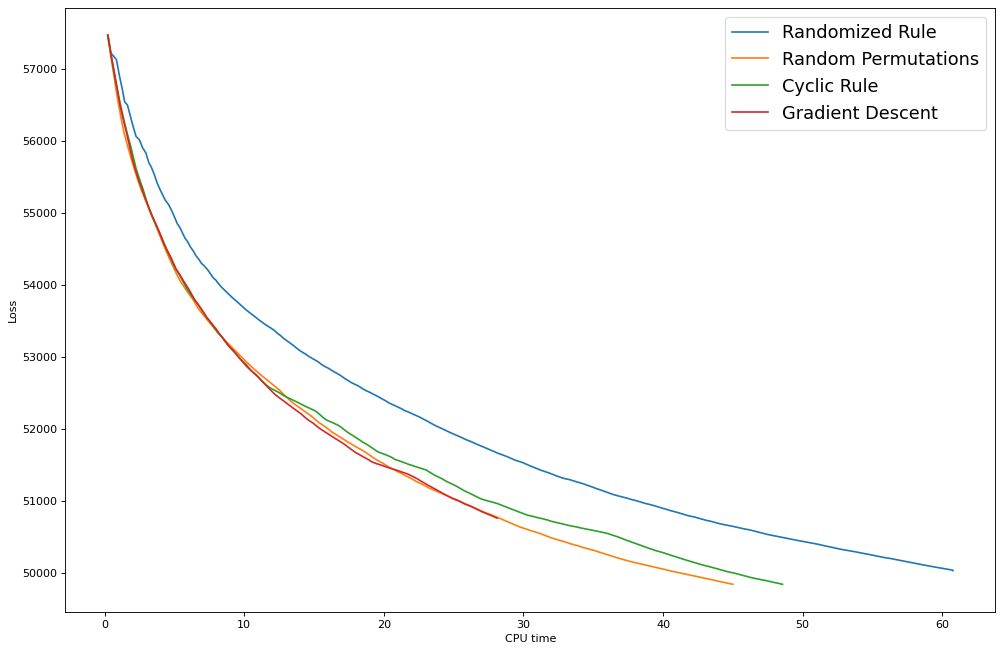

In [38]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=80)
# plt.xlim(-1, 20)
# plt.ylim(65000, 77500)
plt.plot(cpu_time_rrr, func_values_rrr[:-1], label = "Randomized Rule")
plt.plot(cpu_time_rr, func_values_rr[:-1], label = "Random Permutations")
plt.plot(cpu_time_cr, func_values_cr[:-1], label = "Cyclic Rule")
plt.plot(cpu_time_gd, func_values_gd[:-1], label = "Gradient Descent")

ax.set_ylabel("Loss")
ax.set_xlabel("CPU time")
plt.legend(loc=1, prop={'size': 16})
# plt.savefig(fname = "Loss_vs_iterations")
plt.show()